In [1]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd
import geopandas as gpd
import fiona

In [2]:
def shp_lookup(shp_dir, search_prop, query):
    """
    function that returns name of shapefile (.shp) associated with a particualar field
    If looking for shp by city, use

    Args:
        shp_dir : str
            location of shapefiles to be searched
        
        search_prop : str
            field to search for in shapefiles
            (city: 'NAME_2')
            (region/state: 'NAME_1')
        
        query : str
            string to be searched for i.e. 'Delhi'

    Returns:
        str[] : array of filenames of shapefiles
    """
    fnames = []
    
    for filename in os.listdir(shp_dir):
        if filename.endswith(".shp"):
            with fiona.open(shp_dir + filename) as src:
                if src[0]['properties'][search_prop] == query:
                    fnames.append(filename)
    if len(fnames) == 0:
        return "No shapefile exists"
    return fnames

In [3]:
def filter_dataframe(dataframe, search_col, query):
    """
    Filters a pandas dataframe and returns a new dataframe based
    on a query.
    
    Args:
        dataframe : pandas dataframe
            Unfiltered pandas dataframe.
        
        search_col : str
            Column field we are filtering by.
            ex. 'State/UnionTerritory' for covid_19_india.csv
        
        query : str
            value to be searched for i.e. 'Tripura.'
        
    Returns:
        dataframe : New dataframe filtered by the column field
                    and query.
        """
    conditional = dataframe[search_col] == query
    filtered = dataframe[conditional]
    
    return filtered

In [4]:
# Instantiate a dataframe with the covid dataset and one with the testing dataset
covid_df = pd.read_csv("covid_19_india.csv")
test_df = pd.read_csv("StatewiseTestingDetails.csv")

In [5]:
# Read Shapefile
india_shp = gpd.read_file("shapefiles/India_Districts_ADM2_GADM.shp")

In [6]:
# filter the dataframe to the most recent figures
covid_ft = filter_dataframe(covid_df, "Date", "16/11/20")

covid_regions = [] # stores region names
covid_cases = [] # stores confirmed cases

max_cases = 0 # holds the max number of cases for the heat map

# iterates through all states and updates covid_regions and covid_cases and max_cases appropriately
for i in range((int) (covid_ft.size/9)):
    covid_regions.append(covid_ft.iloc[i]["State/UnionTerritory"])
    covid_cases.append(covid_ft.iloc[i]["Confirmed"])
    
    if covid_cases[i] > max_cases:
        max_cases = covid_cases[i]

In [7]:
# filter the dataframe to the most recent figures
test_ft = filter_dataframe(test_df, "Date", "2020-11-15")

test_regions = [] # stores region names
test_tests = [] # stores number of tests performed

max_tests = 0 # holds the max number of tests for the heat map

# iterates through all states and updates test_regions and test_tests
for i in range((int) (test_ft.size/5)):
    test_regions.append(test_ft.iloc[i]["State"])
    test_tests.append(test_ft.iloc[i]["TotalSamples"])
    
    if test_tests[i] > max_tests:
        max_tests = test_tests[i]
        
# getting those annoying edge cases not caught in the final day of testing

test_regions.append("Dadra and Nagar Haveli and Daman and Diu")
test_tests.append(filter_dataframe(filter_dataframe(test_df, "State", "Dadra and Nagar Haveli and Daman and Diu"), "Date", "2020-10-20").iloc[0]["TotalSamples"])

test_regions.append("Maharashtra")
test_tests.append(filter_dataframe(filter_dataframe(test_df, "State", "Maharashtra"), "Date", "2020-11-13").iloc[0]["TotalSamples"])

test_regions.append("Manipur")
test_tests.append(filter_dataframe(filter_dataframe(test_df, "State", "Manipur"), "Date", "2020-11-14").iloc[0]["TotalSamples"])

test_regions.append("Meghalaya")
test_tests.append(filter_dataframe(filter_dataframe(test_df, "State", "Meghalaya"), "Date", "2020-11-14").iloc[0]["TotalSamples"])

# finds the max_tests value for the heat map
for i in range(len(test_regions)):
    if test_tests[i] > max_tests:
        max_tests = test_tests[i]

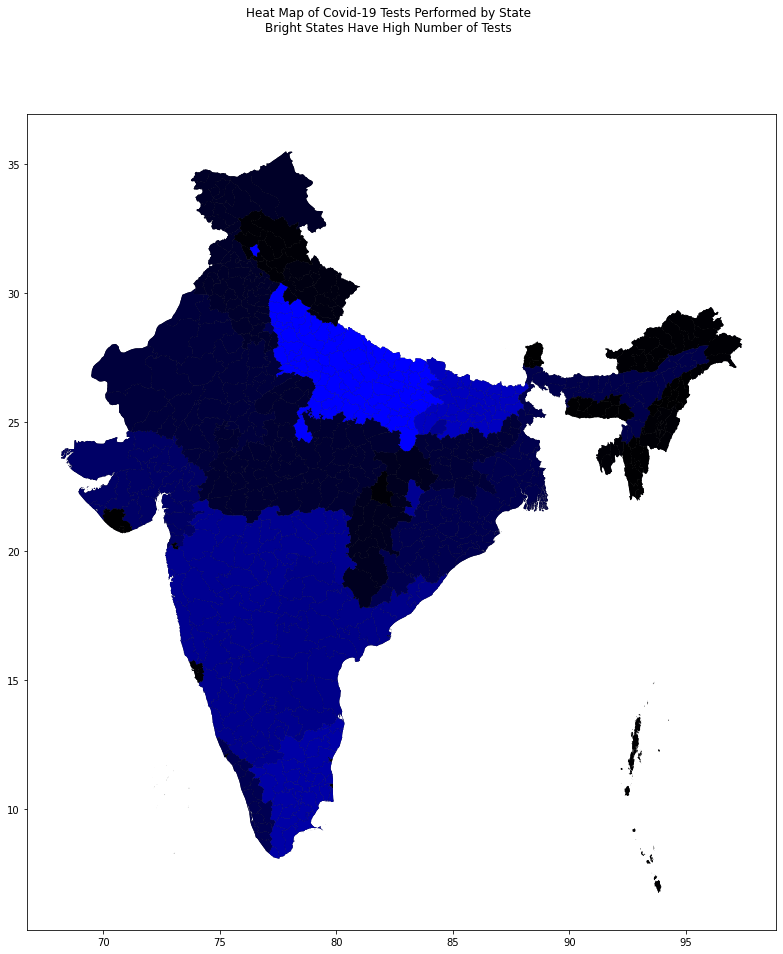

In [8]:
# display shapefile
fig, ax = plt.subplots(figsize=(15,15))
fig.suptitle("Heat Map of Covid-19 Tests Performed by State\nBright States Have High Number of Tests")
india_shp.plot(ax = ax, color=(0,0,0))

# iterates over all regions
for i in range(len(test_regions)):
    # checks if shapefile uses an outdated name for a region/state and gets the correct districts
    if test_regions[i] == "Andaman and Nicobar Islands":
        fnames = shp_lookup(r'shapefiles/regions/', 'NAME_1', "Andaman and Nicobar")
    elif test_regions[i] == "Odisha":
        fnames = shp_lookup(r'shapefiles/regions/', 'NAME_1', "Orissa")
    elif test_regions[i] == "Uttarakhand":
        fnames = shp_lookup(r'shapefiles/regions/', 'NAME_1', "Uttaranchal")
    elif test_regions[i] == "Dadra and Nagar Haveli and Daman and Diu":
        fnames = shp_lookup(r'shapefiles/regions/', 'NAME_1', "Dadra and Nagar Haveli") + shp_lookup(r'shapefiles/regions/', 'NAME_1', "Daman and Diu")
    else:
        fnames = shp_lookup(r'shapefiles/regions/', 'NAME_1', test_regions[i])
    
    if fnames != "No shapefile exists":
        for j in range(len(fnames)):
            district_shp = gpd.read_file(r'shapefiles/regions/' + fnames[j]) # reads the shp file
            district_shp.plot(ax = ax, color=(0,0,test_tests[i]/max_tests)) # plots the district with a blue hue

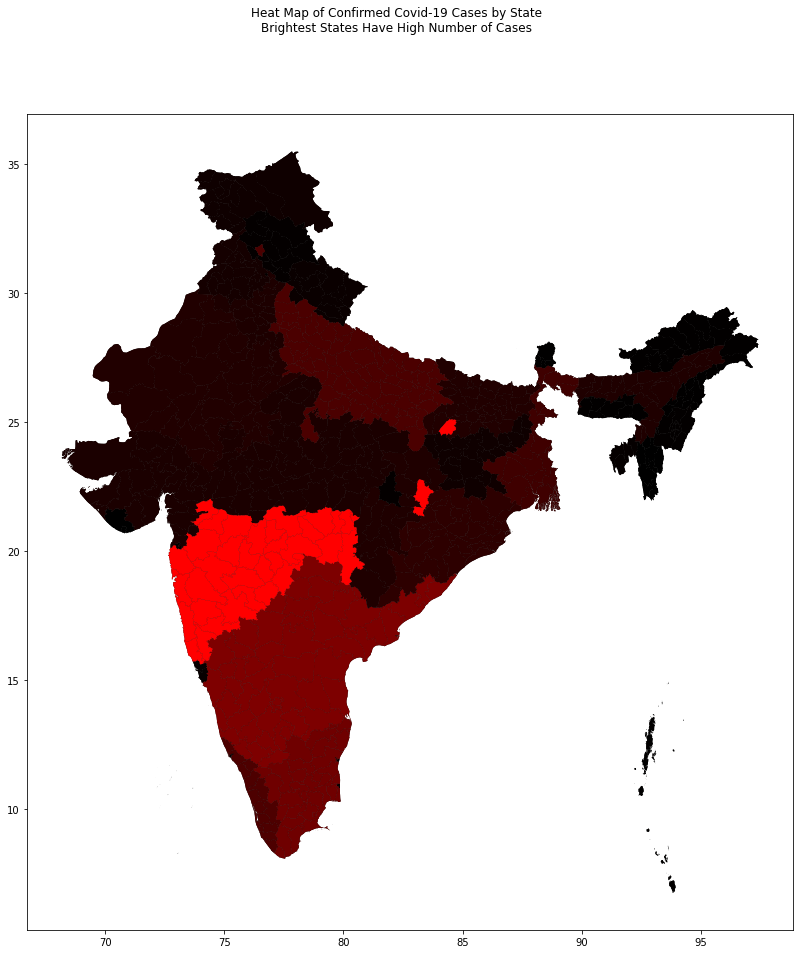

In [9]:
# display shapefile
fig, ax = plt.subplots(figsize=(15,15))
fig.suptitle("Heat Map of Confirmed Covid-19 Cases by State\nBrightest States Have High Number of Cases")
india_shp.plot(ax = ax, color=(0,0,0))

# iterates over all regions
for i in range(len(covid_regions)):
    # checks if shapefile uses an outdated name for a region/state and gets the correct districts
    if covid_regions[i] == "Andaman and Nicobar Islands":
        fnames = shp_lookup(r'shapefiles/regions/', 'NAME_1', "Andaman and Nicobar")
    elif covid_regions[i] == "Odisha":
        fnames = shp_lookup(r'shapefiles/regions/', 'NAME_1', "Orissa")
    elif covid_regions[i] == "Uttarakhand":
        fnames = shp_lookup(r'shapefiles/regions/', 'NAME_1', "Uttaranchal")
    elif covid_regions[i] == "Dadra and Nagar Haveli and Daman and Diu":
        fnames = shp_lookup(r'shapefiles/regions/', 'NAME_1', "Dadra and Nagar Haveli") + shp_lookup(r'shapefiles/regions/', 'NAME_1', "Daman and Diu")
    else:
        fnames = shp_lookup(r'shapefiles/regions/', 'NAME_1', covid_regions[i])
    
    if fnames != "No shapefile exists":
        for j in range(len(fnames)):
            district_shp = gpd.read_file(r'shapefiles/regions/' + fnames[j]) # reads the shp file
            district_shp.plot(ax = ax, color=(covid_cases[i]/max_cases,0,0)) # plots the district with a red hue